In [1]:
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt

if Path.cwd().name != 'src':
    os.chdir('/nfs/home/vaschetti/maxarSrc/')

Print all the events' name

In [2]:
from maxarseg.assemble import names
events_names = names.get_all_events()
for i, e_n in enumerate(events_names):
    print(i, e_n)

0 BayofBengal-Cyclone-Mocha-May-23
1 Emilia-Romagna-Italy-flooding-may23
2 Gambia-flooding-8-11-2022
3 Hurricane-Fiona-9-19-2022
4 Hurricane-Ian-9-26-2022
5 Hurricane-Idalia-Florida-Aug23
6 India-Floods-Oct-2023
7 Indonesia-Earthquake22
8 Kahramanmaras-turkey-earthquake-23
9 Kalehe-DRC-Flooding-5-8-23
10 Libya-Floods-Sept-2023
11 Marshall-Fire-21-Update
12 Maui-Hawaii-fires-Aug-23
13 Morocco-Earthquake-Sept-2023
14 NWT-Canada-Aug-23
15 New-Zealand-Flooding23
16 Sudan-flooding-8-22-2022
17 afghanistan-earthquake22
18 cyclone-emnati22
19 kentucky-flooding-7-29-2022
20 pakistan-flooding22
21 shovi-georgia-landslide-8Aug23
22 southafrica-flooding22
23 tonga-volcano21
24 yellowstone-flooding22


**Set some parameters** used in the segmentation phase, such as batch size and device. </br>
Also it instantiate both the **GroundingDino** model and the **Efficent SAM** model  

In [3]:
from maxarseg.configs import SegmentConfig, DetectConfig
config = SegmentConfig(batch_size = 2,
                        device='cpu',
                        size = 600,
                        stride = 400,
                        use_separate_detect_config = True,
                        clean_masks_bool=True
                        )

det_config = DetectConfig(DF_batch_size = 1,
                        GD_batch_size= 1,
                        device='cpu',
                        size = 600,
                        stride = 600,
                        TEXT_PROMPT='bush',
                        BOX_THRESHOLD = 0.12,
                        DF_patch_size = 400,
                        DF_patch_overlap = 0.25,
                        min_ratio_GD_boxes_edges=0.5,
                        max_area_GD_boxes_mt2 = 6000,
                        nms_threshold=0.2
                        )

- Efficient SAM device: cpu


Build an Event (e.g. 'Gambia-flooding-8-11-2022')</br>
Print its region and the names of its mosaics</br>
Print the number of tiles contained in the first mosaic


In [4]:
from maxarseg.assemble import holders

event = holders.Event(events_names[15],
                    seg_config = None,
                    det_config = None,
                    when='pre')
print(event.region_name)

all_mosaics_names = event.all_mosaics_names
print(all_mosaics_names)

m0 = event.mosaics[all_mosaics_names[0]]
print(f'Number of tiles: {m0.tiles_num}')

Creating event: New-Zealand-Flooding23
Region: Oceania-Full
Mosaics: ['104001007C86B200', '10300100DE4D9300']
Oceania-Full
['104001007C86B200', '10300100DE4D9300']
Number of tiles: 11


In [5]:
m0.set_build_gdf()


Buildings: found 0 links matching: [311333000, 3113330, 31133300]
MS-Buildings: No buildings for this region
No buildings found for this mosaic either in Ms Buildings or in Google Open Buildings


False

In [6]:
m0.build_gdf

In [7]:
m0.proj_build_gdf

In [8]:
m0.segment_all_tiles('/nfs/home/vaschetti/maxarSrc/output/tiff/test2')


Buildings: found 0 links matching: [311333000, 3113330, 31133300]
MS-Buildings: No buildings for this region
No buildings found for this mosaic either in Ms Buildings or in Google Open Buildings


False

In [10]:
event.seg_all_mosaics('/nfs/home/vaschetti/maxarSrc/output/tiff/test2')


Buildings: found 0 links matching: [311333000, 3113330, 31133300]
MS-Buildings: No buildings for this region
No buildings found for this mosaic either in Ms Buildings or in Google Open Buildings
Buildings footprint not available for mosaic: 104001007C86B200. Proceeding to next mosaic...

Buildings: found 0 links matching: [311333000, 3113330, 31133300]
MS-Buildings: No buildings for this region
No buildings found for this mosaic either in Ms Buildings or in Google Open Buildings
Buildings footprint not available for mosaic: 10300100DE4D9300. Proceeding to next mosaic...


In [42]:
from maxarseg.geo_datasets import geoDatasets
from maxarseg.samplers import samplers, samplers_utils
from torch.utils.data import DataLoader
from torchgeo.datasets import stack_samples

tile_path = m0.tiles_paths[0]
dataset = geoDatasets.MxrSingleTileNoEmpty(str(tile_path))
sampler = samplers.BatchGridGeoSampler(dataset,
                                        batch_size=2,
                                        size=600,
                                        stride=600)
dataloader = DataLoader(dataset , batch_sampler=sampler, collate_fn=stack_samples)

In [50]:
m0.tiles_paths[0]

PosixPath('/nfs/projects/overwatch/maxar-segmentation/maxar-open-data/Gambia-flooding-8-11-2022/pre/105001002BD68F00/033133031230.tif')

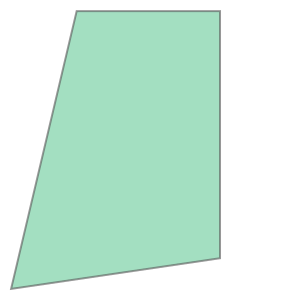

In [43]:
dataset.tile_aoi

In [44]:
list(dataset.tile_aoi.exterior.coords)

[(315156.25, 1490156.25),
 (315156.25, 1489627.3803710938),
 (314709.1666022906, 1489561.7566929795),
 (314849.47218995413, 1490156.25),
 (315156.25, 1490156.25)]

In [46]:
dims = samplers_utils.tile_sizes(dataset)
canvas = np.full(dims, fill_value = True, dtype=bool)
canvas.shape

(17408, 17408)

In [51]:
import rasterio
with rasterio.open(tile_path) as src:
    transform = src.transform
    tile_h = src.height
    tile_w = src.width
transform

Affine(0.30517578125, 0.0, 309843.75,
       0.0, -0.30517578125, 1490156.25)

In [53]:
tile_h, tile_w

(17408, 17408)

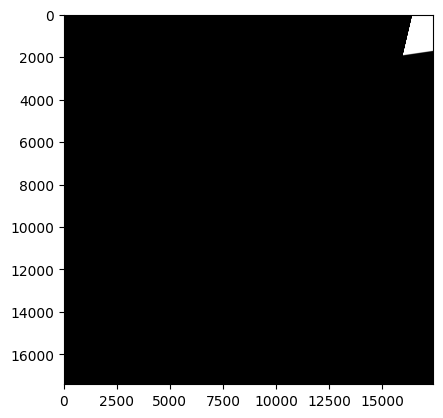

In [48]:
from rasterio.features import rasterize

raster = rasterize([dataset.tile_aoi], out_shape = canvas.shape, fill=False, default_value=True, transform = dataset.transform)
plt.imshow(raster, cmap='gray')

In [34]:
raster[-1, 1]

0

In [40]:
import numpy as np

unique_values = np.unique(raster)
print(unique_values)

[ 4 12]


In [20]:
dataset.transform

Affine(0.30517578125, 0.0, 309843.75,
       0.0, -0.30517578125, 1490156.25)

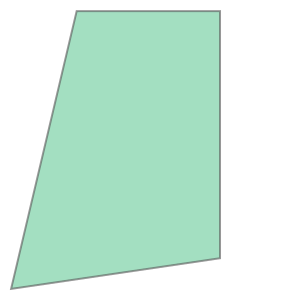

In [21]:
dataset.tile_aoi

In [35]:
list(dataset.tile_aoi.exterior.coords)

[(315156.25, 1490156.25),
 (315156.25, 1489627.3803710938),
 (314709.1666022906, 1489561.7566929795),
 (314849.47218995413, 1490156.25),
 (315156.25, 1490156.25)]

In [ ]:
rasterize(buffered_lines, out_shape=(tile_h, tile_w), transform=transform)

In [28]:
from rasterio.features import geometry_mask
mask = geometry_mask([dataset.tile_aoi], out_shape=canvas.shape, invert=False)


TypeError: geometry_mask() missing 1 required positional argument: 'transform'

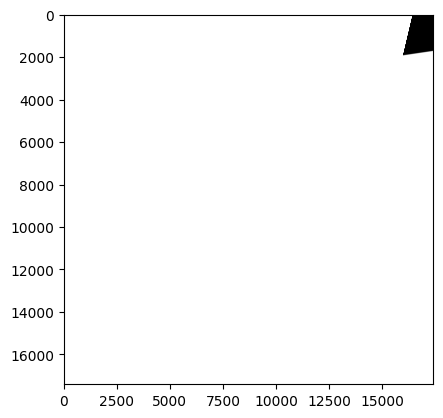

In [27]:
plt.imshow(mask, cmap='gray')

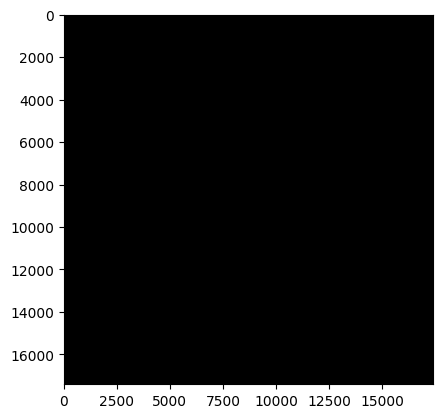

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Plot the binary array
plt.imshow(raster, cmap='gray')
plt.show()


Set the geodataframe of the **building** of the first mosaic

In [5]:
m0.set_build_gdf()


Buildings: found 3 links matching: [33303200, 333032, 3330320]


In [6]:
m0.tiles_paths[17]

PosixPath('/nfs/projects/overwatch/maxar-segmentation/maxar-open-data/Gambia-flooding-8-11-2022/pre/10300100CFC9A500/033133031233.tif')

In [7]:
m0.segment_tile(m0.tiles_paths[17],
                out_dir_root='./output/tiff/to_del_all3_clean',
                glbl_det = True,
                separate_masks = False)

Roads: reading roads for the whole AfricaWest-Full region
Roads: not in USA. Region name: AfricaWest-Full.tsv
Roads in 10300100CFC9A500 mosaic: 18325
final text_encoder_type: bert-base-uncased

- GD model device: cuda:2


Detecting Trees:  90%|█████████ | 810/900 [03:38<00:24,  3.70it/s]


Discarded empty chips:  90
True num of batch:  810.0
Reading config file: ./.venv/lib/python3.10/site-packages/deepforest/data/deepforest_config.yml
setting config devices to [2]
setting config score_thresh to 0.1
setting config accelerator to cuda


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


No validation file provided. Turning off validation loop
Model from DeepForest release https://github.com/weecology/DeepForest/releases/tag/1.0.0 was already downloaded. Loading model from file.
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Predicting: |          | 0/? [00:00<?, ?it/s]

52953 predictions in overlapping windows, applying non-max supression
32521 predictions kept after non-max suppression
Number of tree boxes before filtering:  117652
boxes area filtering:  8870 boxes removed
box edge ratio filtering: 25505 boxes removed
nms filtering: 32108 boxes removed
Number of tree boxes after all filtering:  51169


Segmenting:   3%|▎         | 25/968 [01:00<37:44,  2.40s/it]



Total Time for 52 images:  60.42382574081421
Cleaning the masks: holes_area_th =  80 small_obj_area =  80
Mask written in ./output/tiff/to_del_all3_clean/Gambia-flooding-8-11-2022/pre/10300100CFC9A500/033133031233.tif


TypeError: cannot unpack non-iterable NoneType object

In [9]:
canvas = m0.seg_glb_tree_and_build_tile(m0.tiles_paths[17], debug_param_trees_gdf = tree_gdf)

  5%|▌         | 50/968 [02:19<42:44,  2.79s/it]  



Total Time for 102 images:  140.41555500030518


In [11]:
output.single_mask2Tif(m0.tiles_paths[17], canvas[1], out_name = "glbl_test_build.tif")

Mask written in ./output/tiff/glbl_test_build.tif


In [ ]:
m0.segment_tile(m0.tiles_paths[17], "./output/tiff")

Otherwise, to get the numpy masks...

In [ ]:
#Trees and buildings
canvas = m0.seg_tree_and_build_tile(m0.tiles_paths[17])

#Eventually save the numpy masks
np.save('./output/canvas_1.npy', canvas)

In [ ]:
#road
road_mask = m0.seg_road_tile(m0.tiles_paths[17], road_width_mt = 5)

Remove possible overlap between masks

In [ ]:
overlap_masks = np.concatenate((np.expand_dims(road_mask, axis=0), canvas[:-1]) , axis = 0)
no_overlap_masks = segment_utils.rmv_mask_overlap(overlap_masks)

Save to .tif

In [ ]:
names = ['road', 'tree', 'building']
for i, name in enumerate(names):
    out_name = 'second_try_whole_' + name + '.tif'
    output.single_mask2Tif(m0.tiles_paths[17], no_overlap_masks[i], out_name)

## End

In [ ]:
def seg_tree_and_build_tile(self, tile_path):
    seg_config = self.event.seg_config

    dataset = geoDatasets.MxrSingleTile(str(tile_path))
    sampler = samplers.WholeTifGridGeoSampler(dataset, batch_size=seg_config.batch_size, size=seg_config.size, stride=seg_config.stride)
    dataloader = DataLoader(dataset , batch_sampler=sampler, collate_fn=stack_samples)

    canvas = np.zeros((3,) + samplers_utils.tile_sizes(dataset), dtype=np.uint8) #dim (3, h_tile, w_tile). The first dim is: tree, build, pad
    
    all_batches_img_ixs = np.arange(len(sampler)*seg_config.batch_size).reshape((-1, seg_config.batch_size))
    _, total_cols = sampler.get_num_rows_cols()
    
    #f_i = 30
    
    #TIMERS
    GD_total = 0
    build_box_total = 0
    Esam_total = 0
    post_proc_total = 0
    
    start_time_all = time()
    for batch_ix, batch in tqdm(enumerate(dataloader), total = len(dataloader)):
        original_img_tsr = batch['image']
        img_b = batch['image'].permute(0,2,3,1).numpy().astype('uint8') #TODO: l'immagine viene convertita in numpy ma magari è meglio lasciarla in tensor

        #trees
        #GD_t_0 = time()
        
        #get the tree boxes in batches and the number of trees for each image
        GD_start = time()
        tree_boxes_b, num_trees4img = detect.get_GD_boxes(img_b,
                                            seg_config.GD_model,
                                            seg_config.TEXT_PROMPT,
                                            seg_config.BOX_THRESHOLD,
                                            seg_config.TEXT_THRESHOLD,
                                            dataset.res,
                                            device = seg_config.device,
                                            max_area_mt2 = seg_config.max_area_GD_boxes_mt2)
        GD_total += time() - GD_start
        #tree_boxes_b è una lista con degli array di shape (n, 4) dove n è il numero di tree boxes
        
        #print('GD_time: ', time() - GD_t_0)

        #get the building boxes in batches and the number of buildings for each image
        build_box_start = time()
        building_boxes_b, num_build4img = detect.get_batch_buildings_boxes(batch['bbox'],
                                                                    proj_buildings_gdf = self.proj_build_gdf,
                                                                    dataset_res = dataset.res,
                                                                    ext_mt = 10)
        build_box_total += time() - build_box_start
        
        #building_boxes_b è una lista con degli array di shape (n, 4) dove n è il numero di building boxes
        
        max_detect = max(num_trees4img + num_build4img)
        
        #print("\n__________________________")
        #print("Batch number: ", i)
        #print(f'Num detections in batch per img: {num_trees4img + num_build4img}')
        
        #obtain the right input for the ESAM model (trees + buildings)
        input_points, input_labels = segment_utils.get_input_pts_and_lbs(tree_boxes_b, building_boxes_b, max_detect)
        
        # segment the image and get for each image as many masks as the number of boxes,
        # for GPU constraint use num_parall_queries
        ESAM_start = time()
        all_masks_b = segment.ESAM_from_inputs(original_img_tsr,
                                                torch.from_numpy(input_points),
                                                torch.from_numpy(input_labels),
                                                efficient_sam = seg_config.efficient_sam,
                                                device = seg_config.device,
                                                num_parall_queries = 5)
        Esam_total += time() - ESAM_start
        
        
        #for each image, discern the masks in trees, buildings and padding
        post_proc_start = time()
        patch_masks_b = segment_utils.discern_mode(all_masks_b, num_trees4img, num_build4img, mode = 'bchw')
        
        canvas = segment_utils.write_canvas(canvas = canvas,
                                            patch_masks_b =  patch_masks_b,
                                            img_ixs = all_batches_img_ixs[batch_ix],
                                            stride = seg_config.stride,
                                            total_cols = total_cols)
        post_proc_total += time() - post_proc_start
        
        if batch_ix%100 == 0:
            print('Avg times (sec/batch)')
            print(f'- GD: {(GD_total/(batch_ix + 1)):.4f}')
            print(f'- build_box: {(build_box_total/(batch_ix + 1)):.4f}')
            print(f'- ESAM: {(Esam_total/(batch_ix + 1)):.4f}')
            print(f'- post_proc: {(post_proc_total/(batch_ix + 1)):.4f}')
            #TODO: aggiundere qui un metodo per debug che ti fa vedere una patch con segmentazione e boxes
        
        #if batch_ix == f_i:
        #    break
        
    print(f'\nTotal Time for {seg_config.batch_size * (batch_ix + 1)} images: ', time() - start_time_all)
    #TODO: aggiungere metodo per postproces mask, convertire in tif e salvare
    
    return canvas

canvas = seg_tree_and_build_tile(m0, m0.tiles_paths[17])
#img_b, original_img, tree_boxes_b, building_boxes_b, all_masks_b, tree_mask_b, building_mask_b, pad_mask_b = segment_tile(m0, m0.tiles_paths[17])

Avg times (sec/batch)
- GD: 0.4950
- build_box: 0.0043
- ESAM: 2.6371
- post_proc: 0.0487

In totale ci ha messo 1,5h size 600, stride 300. Ha processato 3364 patches.</br>
Ci mette circa 1.61 sec a immagine

Ho notato che il tempo che ci mette ESAM aumenta man mano

In [50]:
#Eventually save the numpy masks
np.save('./output/canvas_1.npy', canvas)

In [47]:
road_mask = m0.seg_road_tile(m0.tiles_paths[17], road_width_mt = 5)

In [48]:
overlap_masks = np.concatenate((np.expand_dims(road_mask, axis=0), canvas[:-1]) , axis = 0)
no_overlap_masks = segment_utils.rmv_mask_overlap(overlap_masks)

In [49]:
names = ['road', 'tree', 'building']
for i, name in enumerate(names):
    out_name = 'firt_try_whole_' + name + '.tif'
    output.single_mask2Tif(m0.tiles_paths[17], no_overlap_masks[i], out_name)

Mask written in ./output/firt_try_whole_road.tif
Mask written in ./output/firt_try_whole_tree.tif
Mask written in ./output/firt_try_whole_building.tif


In [27]:
output.single_mask2Tif(m0.tiles_paths[17], no_overlap_masks[2], 'test_no_over_build.tif')

Mask written in ./output/test_no_over_build.tif


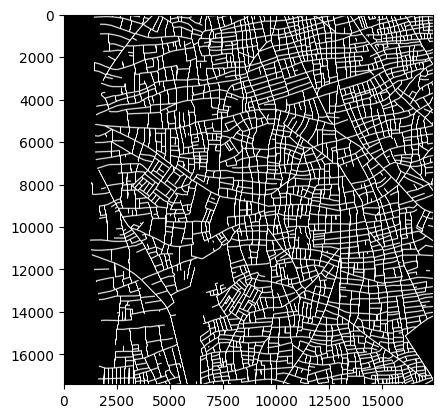

In [14]:
import matplotlib.pyplot as plt

# Visualize the array
plt.imshow(road_mask, cmap='gray')
plt.show()

In [ ]:
segment_utils.rmv_mask_overlap()

In [51]:
cv = np.load('./output/canvas.npy')
cv.shape

(3, 17408, 17408)

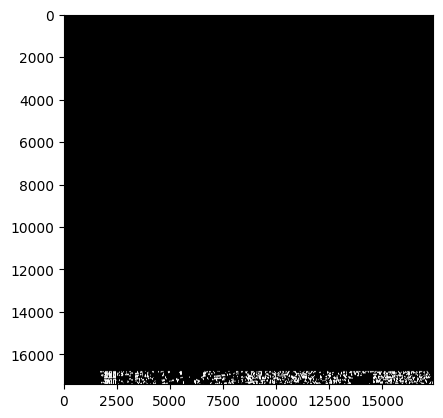

In [45]:
import matplotlib.pyplot as plt

# Visualize the array
plt.imshow(canvas[1], cmap='gray')
plt.show()

In [12]:
output.single_mask2Tif(m0.tiles_paths[17], canvas[1], 'test_build_2.tif')

Mask written in ./output/test_build_2.tif


In [21]:
def single_mask2Tif(tile_path, mask, out_name, out_path_root = './output'):
    with rasterio.open(tile_path) as src:
        out_meta = src.meta.copy()
    
    out_meta.update({"driver": "GTiff",
                     "dtype": "uint8",
                     "count": 1})
    out_path = out_path_root + '/'+ out_name
    with rasterio.open(out_path, 'w', **out_meta) as dest:
            dest.write(mask, 1)

In [22]:
single_mask2Tif(m0.tiles_paths[17], canvas[0], 'test_trees.tif')

In [ ]:
#Top, working

self = m0
tile_path = m0.tiles_paths[17]

seg_config = self.event.seg_config
dataset = geoDatasets.Maxar(str(tile_path))
sampler = samplers.MyBatchGridGeoSampler(dataset, batch_size=seg_config.batch_size, size=seg_config.size, stride=seg_config.stride)
dataloader = DataLoader(dataset , batch_sampler=sampler, collate_fn=stack_samples)

canvas = np.zeros((seg_config.size, seg_config.size, 3), dtype=np.uint8)
i = 0
f_i = 2
for batch in tqdm(dataloader):
    i+=1
    """if i != f_i:
        i+=1
        continue"""
    original_img_tsr = batch['image']
    img_b = batch['image'].permute(0,2,3,1).numpy().astype('uint8') #TODO: l'immagine viene convertita in numpy ma magari è meglio lasciarla in tensor
    
    #get the tree boxes in batches and the number of trees for each image
    tree_boxes_b, num_trees4img = detect.get_GD_boxes(img_b, seg_config.GD_model,
                                        seg_config.TEXT_PROMPT,
                                        seg_config.BOX_THRESHOLD,
                                        seg_config.TEXT_THRESHOLD,
                                        dataset.res,
                                        device = seg_config.device,
                                        max_area_mt2 = seg_config.max_area_GD_boxes_mt2)
    
    #get the building boxes in batches and the number of buildings for each image
    building_boxes_b, num_build4img = detect.get_batch_buildings_boxes(batch['bbox'],
                                                                proj_buildings_gdf = self.proj_build_gdf,
                                                                dataset_res = dataset.res,
                                                                ext_mt = 10)
    max_detect = max(num_trees4img + num_build4img)
    print("\n__________________________")
    print("Batch number: ", i)
    print(f'Num detections in batch: {num_trees4img + num_build4img}')
    
    #obtain the right input for the ESAM model (trees + buildings)
    input_points, input_labels = segment_utils.get_input_pts_and_lbs(tree_boxes_b, building_boxes_b, max_detect)
    
    # segment the image and get for each image as many masks as the number of boxes,
    # for GPU constraint use num_parall_queries
    all_masks_b = segment.ESAM_from_inputs(original_img_tsr,
                                            torch.from_numpy(input_points),
                                            torch.from_numpy(input_labels),
                                            efficient_sam = seg_config.efficient_sam,
                                            device = seg_config.device,
                                            num_parall_queries = 5)
    
    #for each image, discern the masks in trees, buildings and padding
    tree_mask_b, building_mask_b, pad_mask_b = segment_utils.discern(all_masks_b, num_trees4img, num_build4img)
    
    if i == f_i:
        break

In [2]:
import os
output_root_path = './output/tiff/pre/10300100CFC9A500'
if not os.path.exists(output_root_path):
    os.makedirs(output_root_path)

In [10]:
from pathlib import Path
p = Path('/nfs/projects/overwatch/maxar-segmentation/maxar-open-data/BayofBengal-Cyclone-Mocha-May-23/pre/10300100E6747500/033111330333.tif')

In [15]:
ev_name, tl_when, mos_name, tl_name = tile_path.parts[-4:]
masks_names = ['road', 'tree', 'building']
out_names = [Path(ev_name) / tl_when / mos_name / (tl_name.split('.')[0] + '_' + mask_name + '.tif') for mask_name in masks_names]

In [11]:
p.parts[-4:]

('BayofBengal-Cyclone-Mocha-May-23',
 'pre',
 '10300100E6747500',
 '033111330333.tif')

In [16]:
out_names

[PosixPath('BayofBengal-Cyclone-Mocha-May-23/pre/10300100E6747500/033111330333_road.tif'),
 PosixPath('BayofBengal-Cyclone-Mocha-May-23/pre/10300100E6747500/033111330333_tree.tif'),
 PosixPath('BayofBengal-Cyclone-Mocha-May-23/pre/10300100E6747500/033111330333_building.tif')]

In [23]:
out_names[0].parent

PosixPath('BayofBengal-Cyclone-Mocha-May-23/pre/10300100E6747500')

In [26]:
import os
output_root_path = "./output/tiff"
output_root_path = Path(output_root_path)
output_root_path / out_names[0].parent
if not os.path.exists(out_names[0].parent):
    os.makedirs(output_root_path / out_names[0].parent)

In [27]:
output_root_path / out_names[0].parent

PosixPath('./output/tiff/BayofBengal-Cyclone-Mocha-May-23/pre/10300100E6747500')

In [ ]:
./output

In [29]:
pa = output_root_path / out_names[0].parent
pa.mkdir(parents=True, exist_ok=True)

In [37]:
out_dir_root = "./output/tiff"
tile_path = m0.tiles_paths[17]

tile_path = Path(tile_path)
out_dir_root = Path(out_dir_root)

ev_name, tl_when, mos_name, tl_name = tile_path.parts[-4:]
masks_names = ['road', 'tree', 'building']
out_names = [Path(ev_name) / tl_when / mos_name / (tl_name.split('.')[0] + '_' + mask_name + '.tif') for mask_name in masks_names]        

(out_dir_root / out_names[0]).parent.mkdir(parents=True, exist_ok=True) #create folder if not exists

if not False:
    for out_name in out_names:
        assert not (out_dir_root / out_name).exists(), f'File {out_name} already exists'
